# Retina classifier
This notebook reproduces ["Identifying Medical Diagnoses and Treatable
Diseases by Image-Based Deep Learning"](http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5) using fast.ai pipeline and [data](https://www.kaggle.com/paultimothymooney/kermany2018) from original paper.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

Import all the necessary packages.

In [3]:
from fastai.vision import *
from fastai.metrics import error_rate

In [4]:
bs = 64

## Looking at the data

Define path to dataset

In [5]:
path = Path("/storage_2/retinal_oct_images/OCT2017/")

In [6]:
path.ls()

[PosixPath('/storage_2/retinal_oct_images/OCT2017/test'),
 PosixPath('/storage_2/retinal_oct_images/OCT2017/models'),
 PosixPath('/storage_2/retinal_oct_images/OCT2017/models.zip'),
 PosixPath('/storage_2/retinal_oct_images/OCT2017/val'),
 PosixPath('/storage_2/retinal_oct_images/OCT2017/train')]

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

Here data has ImageNet-like structure, so we would use `from_folder` method. Normalize images with `imagenet_stats`, because we would use pretrained on ImageNet models.

In [7]:
# switch off transforms
tfms = get_transforms(flip_vert=False, do_flip=False, p_affine=0., p_lighting=0., max_zoom=1.)
data = ImageDataBunch.from_folder(path=path, train='train', valid='test',
                                  ds_tfms=tfms, size=224).normalize(imagenet_stats)

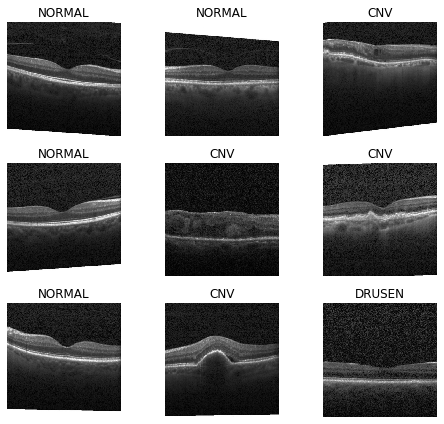

In [8]:
data.show_batch(rows=3, figsize=(7,6))

In [9]:
print(data.classes)
len(data.classes),data.c

['CNV', 'DME', 'DRUSEN', 'NORMAL']


(4, 4)

## Training: resnet50

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [10]:
f1_score = FBeta(beta=1)
learn = cnn_learner(data, models.resnet50, metrics=[error_rate, f1_score], wd=1e-2, ps=0.5)

In [11]:
learn.model;

In [12]:
learn.fit_one_cycle(4, 1e-3)

epoch,train_loss,valid_loss,error_rate,f_beta,time
0,0.224132,0.049172,0.016529,0.983423,04:05
1,0.161470,0.089538,0.034091,0.967461,04:01
2,0.129400,0.033314,0.009298,0.990869,04:01
3,0.104783,0.023376,0.009298,0.990869,04:01


In [13]:
learn.save('resnet50-stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [14]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

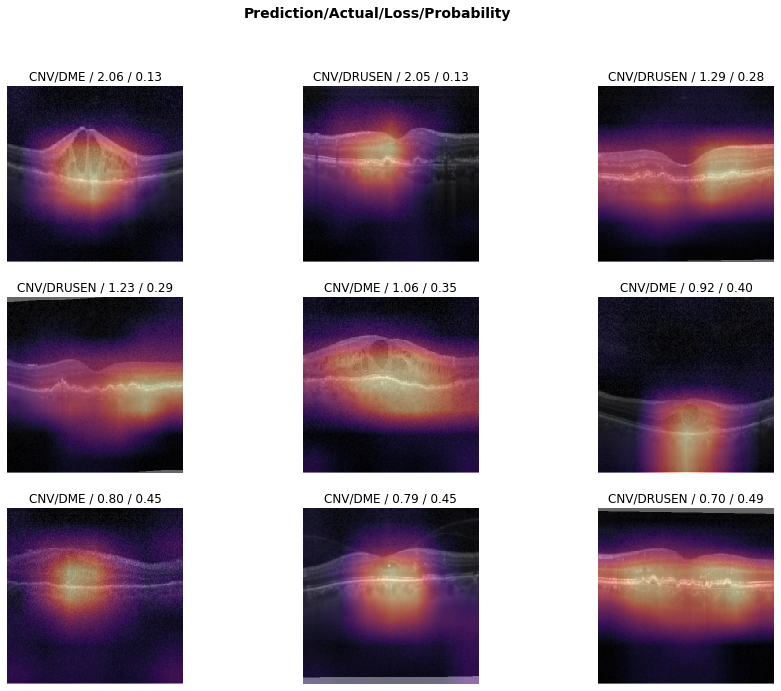

In [15]:
interp.plot_top_losses(9, figsize=(15,11), heatmap=True)

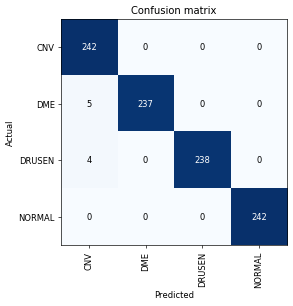

In [16]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [17]:
learn.load('resnet50-stage-1');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


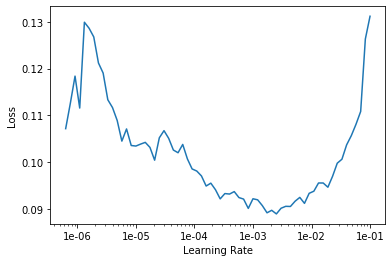

In [18]:
learn.lr_find()
learn.recorder.plot()

In [19]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,error_rate,f_beta,time
0,0.167162,0.223014,0.091942,0.907804,05:14
1,0.118528,0.027386,0.010331,0.989830,05:13
2,0.091444,0.028500,0.007231,0.992870,05:16


That's a pretty accurate model!

In [20]:
learn.save('resnet50-stage-2')

In [21]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

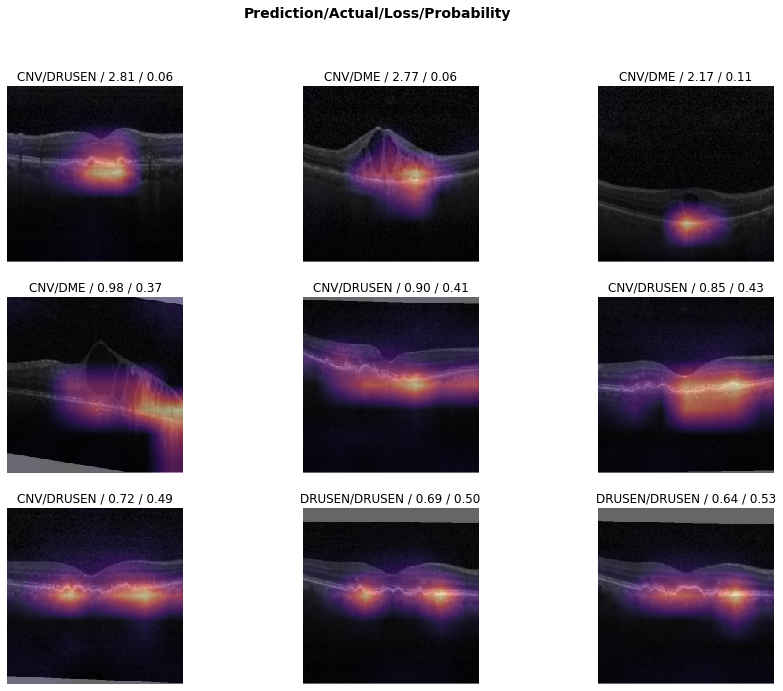

In [22]:
interp.plot_top_losses(9, figsize=(15,11), heatmap=True)

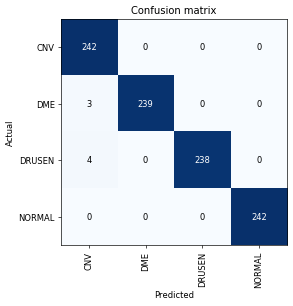

In [23]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

In [24]:
del learn
torch.cuda.empty_cache()

## DenseNet121

In [25]:
f1_score = FBeta(beta=1)
learn = cnn_learner(data, models.densenet121, metrics=[error_rate, f1_score], wd=1e-2, ps=0.5)

In [26]:
learn.model;

In [27]:
learn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,error_rate,f_beta,time
0,0.195813,0.074277,0.027893,0.972183,04:50
1,0.129475,0.049108,0.015496,0.984956,04:48
2,0.105216,0.028293,0.010331,0.989874,04:46


In [28]:
learn.save('densenet121-stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [29]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

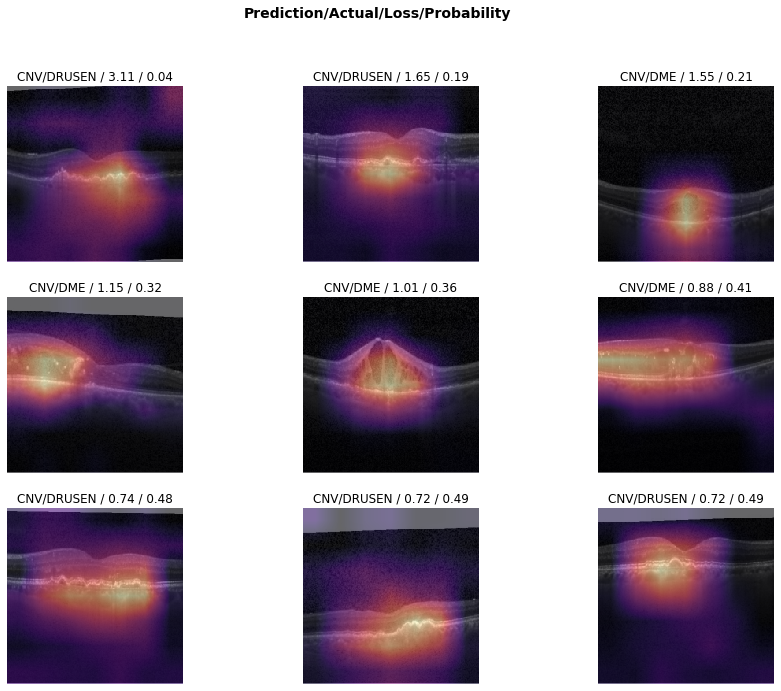

In [30]:
interp.plot_top_losses(9, figsize=(15,11), heatmap=True)

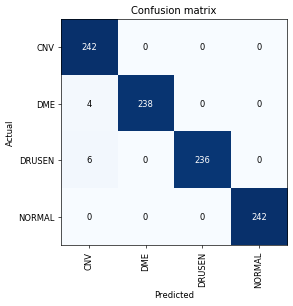

In [31]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [32]:
learn.load('densenet121-stage-1');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


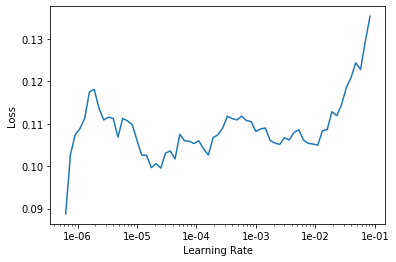

In [33]:
learn.lr_find()
learn.recorder.plot()

In [34]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,error_rate,f_beta,time
0,0.155573,0.050105,0.013430,0.986609,06:17
1,0.123268,0.079300,0.035124,0.967035,06:16
2,0.070943,0.018535,0.006198,0.993877,06:16


That's a pretty accurate model!

In [35]:
learn.save('densenet121-stage-2')

In [36]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

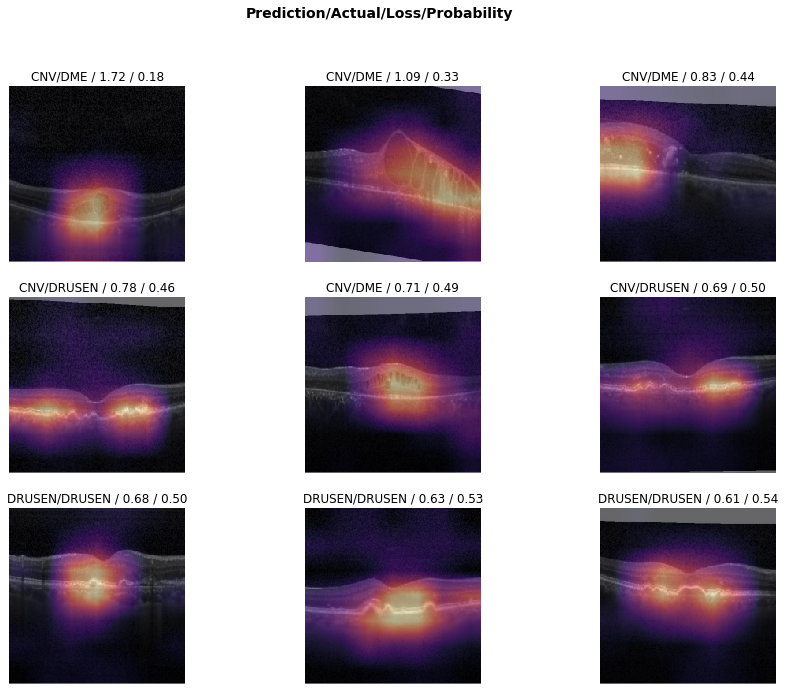

In [37]:
interp.plot_top_losses(9, figsize=(15,11), heatmap=True)

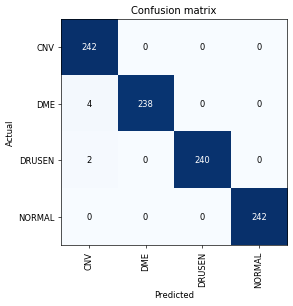

In [38]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

## Conclusion
* DenseNet121 ($F_\beta$-score 0.9934) performed slightly better than ResNet50 ($F_\beta$-score 0.9929)
* We outperformed original papers results in 10 times less epochs, because of incorporated tricks (`fit_one_cycle` learning policy; splitting learning into stages; discriminative learning rates during stage 2 etc.)
* Switched off unnecessary fast.ai transformers (on the fly data augmentation) improves classifier accuracy